In [124]:
import os
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

In [174]:
# Set folder and read TIF files
folder = "data_m/sentinel-2"  # Corrected typo in path
tifs = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith("tif")])
b8, *stack = tifs

In [175]:
b8

'data_m/sentinel-2\\B02.tif'

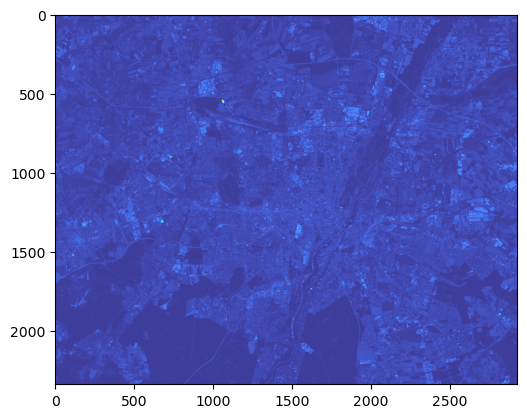

In [176]:
# Read and plot high-resolution raster
with rasterio.open(b8) as src:
    highres = src.read(1)
plt.imshow(highres, cmap='turbo')
plt.show()

In [149]:
def read_bands_sentinel2(directory):
    bands = []
    band_files = ['B02.tif', 'B03.tif', 'B04.tif', 'B05.tif', 'B06.tif', 'B07.tif', 'B08.tif', 'B8A.tif']
    for band_file in band_files:
        file_path = f"{directory}/{band_file}"
        with rasterio.open(file_path) as dataset:
            bands.append(dataset.read(1))
    return bands

# Sentinel-2 bands
sentinel2_bands = read_bands_sentinel2("data_m/sentinel-2")

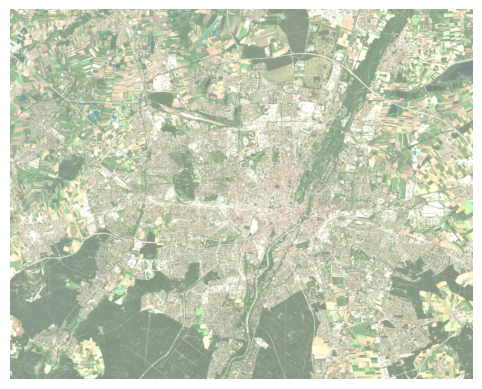

In [152]:
import numpy as np

# Visualization function for Sentinel-2
def visualize_sentinel2(sentinel2_bands, upper_percentile):
    # Standard RGB composite for Sentinel-2: B04 (Red), B03 (Green), B02 (Blue)
    rgb = np.stack([sentinel2_bands[2], sentinel2_bands[1], sentinel2_bands[0]], axis=-1)
    max_val = np.percentile(rgb, upper_percentile * 100)
    rgb_normalized = np.clip(rgb, 0, max_val) / max_val
    plt.imshow(rgb_normalized)
    plt.axis('off')
    plt.show()

visualize_sentinel2(sentinel2_bands, 0.90)

In [132]:
sentinel2_bands[0]

array([[1964, 1433, 1276, ..., 1324, 1295, 1288],
       [1977, 1463, 1295, ..., 1287, 1272, 1284],
       [2006, 1514, 1286, ..., 1277, 1276, 1262],
       ...,
       [1188, 1196, 1201, ..., 1127, 1110, 1160],
       [1191, 1202, 1196, ..., 1117, 1135, 1143],
       [1219, 1227, 1207, ..., 1112, 1143, 1142]], dtype=uint16)

In [133]:
def brightness(sentinel2):
    # Placeholder coefficients for Sentinel-2 brightness index
    b2, b3, b4, b8 = sentinel2[:4]  # Using first four bands as an example
    return b2 * 0.3 + b3 * 0.3 + b4 * 0.3 + b8 * 0.1

def greenness(sentinel2):
    # Placeholder coefficients for Sentinel-2 greenness index
    b2, b3, b4, b8 = sentinel2[:4]  # Using first four bands as an example
    return b3 * 0.5 - b2 * 0.2 - b4 * 0.2 - b8 * 0.1

def wetness(sentinel2):
    # Placeholder coefficients for Sentinel-2 wetness index
    b2, b3, b4, b8 = sentinel2[:4]  # Using first four bands as an example
    return b8 * 0.5 - b3 * 0.2 - b2 * 0.2 - b4 * 0.1

def mndwi(sentinel2):
    green, nir = sentinel2[1], sentinel2[6]  # B03 (Green) and B08 (NIR)
    return (green - nir) / (green + nir + 1e-10)

def ndbi(sentinel2):
    red, nir = sentinel2[2], sentinel2[6]  # B04 (Red) and B08 (NIR)
    return (nir - red) / (nir + red + 1e-10)

def ndvi(sentinel2):
    nir, red = sentinel2[6], sentinel2[2]  # B08 (NIR) and B04 (Red)
    return (nir - red) / (nir + red + 1e-10)

def savi(sentinel2, L=0.5):
    nir, red = sentinel2[6], sentinel2[2]  # B08 (NIR) and B04 (Red)
    return ((nir - red) / (nir + red + L + 1e-10)) * (1 + L)


In [153]:
from rasterio.enums import Resampling
import rasterio

def resample_band(band, target_shape):
    # Adjust band data to target shape
    data = band.read(
        out_shape=target_shape,
        resampling=Resampling.bilinear
    )
    return data

# Define the path to your Sentinel-2 bands
folder = "data_m/sentinel-2"
tifs = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".tif")])

# Assuming you want to resample to the shape of the first band
with rasterio.open(tifs[0]) as first_band:
    target_shape = first_band.shape

# Resample all bands
resampled_bands = []
for tif in tifs:
    with rasterio.open(tif) as band:
        resampled_data = resample_band(band, target_shape=target_shape)
        resampled_bands.append(resampled_data)

In [154]:
sentinel2_bands = resampled_bands

In [155]:
# List of functions
functions = [mndwi, ndbi, ndvi, savi, brightness, greenness, wetness]

# Apply each function to the landsat data
# This will create a list of tuples with the function name and its output raster
smrs = [(func.__name__, func(sentinel2_bands)) for func in functions]

# If you need a dictionary instead of a list of tuples:
smrs_dict = {func.__name__: func(sentinel2_bands) for func in functions}

Shape after squeezing: (2341, 2928)


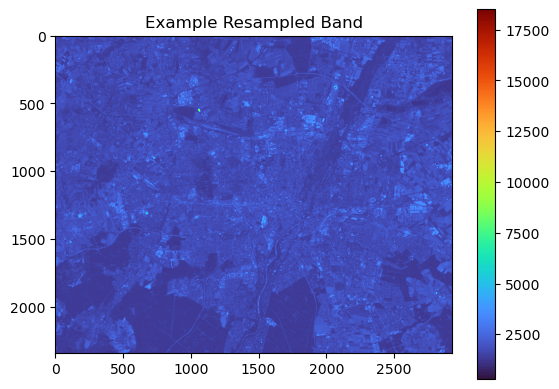

In [156]:
import numpy as np

# Reshape the resampled bands
resampled_bands_2d = [np.squeeze(band) for band in resampled_bands]

# Check the shape again
print("Shape after squeezing:", resampled_bands_2d[0].shape)

# Try plotting again
plt.imshow(resampled_bands_2d[1], cmap='turbo')  # Plotting the second band
plt.colorbar()
plt.title('Example Resampled Band')
plt.show()

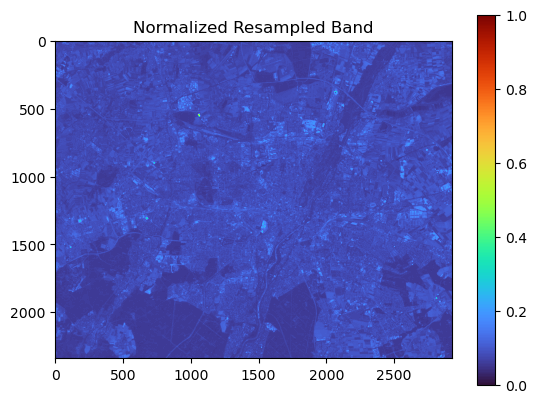

In [157]:
# Normalize the band data for visualization
normalized_band = (resampled_bands_2d[1] - resampled_bands_2d[1].min()) / (resampled_bands_2d[1].max() - resampled_bands_2d[1].min())

plt.imshow(normalized_band, cmap='turbo')
plt.colorbar()
plt.title('Normalized Resampled Band')
plt.show()

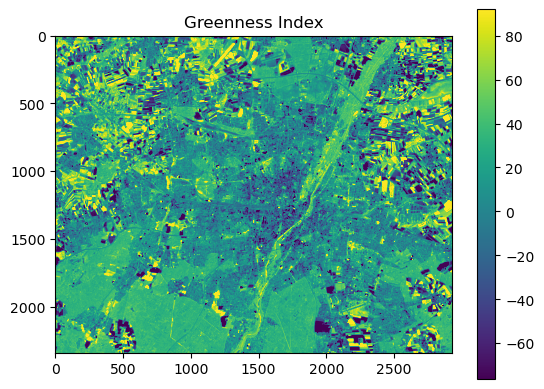

In [167]:
# Squeeze the 'greenness_raster' to ensure it is 2D
greenness_raster_2d = np.squeeze(greenness_raster)

# Now let's recalculate the percentiles on the squeezed array
vmin, vmax = np.percentile(greenness_raster_2d, [5, 95])  # Adjust the percentiles as needed

# Choose a different colormap
cmap = plt.cm.viridis

# Plot the greenness index with the adjusted color scale and colormap
plt.imshow(greenness_raster_2d, cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Greenness Index')
plt.show()

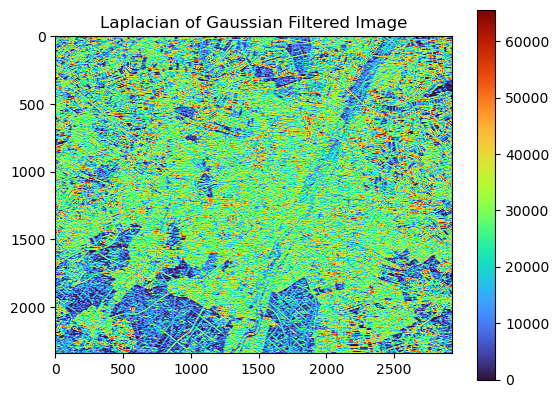

In [168]:
# Apply Laplacian of Gaussian (LoG) and plot the subsection of the filtered image
sigma = 3
out2 = gaussian_laplace(highres, sigma=sigma)
plt.imshow(out2, cmap='turbo')  # Remove the slicing to see the full image
plt.colorbar()
plt.title('Laplacian of Gaussian Filtered Image')
plt.show()

In [177]:
# Resample and create the combined raster stack
with rasterio.open(b8) as src:  # Assuming b8 is still the file path to the B08 band
    affine = src.transform
    crs = src.crs
    target_shape = src.shape

# Assuming `smrs` is a list of tuples with (name, raster) for Sentinel-2
crst = sentinel2_sr + [band for name, band in smrs]

In [31]:
crst

[array([[-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        ...,
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34]], dtype=float32),
 array([[-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-

In [178]:
# Assuming landsat is a list of numpy arrays for each band
landsat_sr = [dn_to_reflectance(band) for band in landsat]
# Now you can replace infinite values with 0.0 for each band
landsat_sr = [np.where(np.isinf(band), 0.0, band) for band in landsat_sr]

In [179]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

# Define the function to convert digital numbers to reflectance for Sentinel-2
def sentinel_dn_to_reflectance(array, band_number, scale_factor, add_constant):
    # The scale factor and add_constant values should be retrieved from the metadata
    # For the sake of this example, we're using placeholders
    # Sentinel-2's scale factor is generally 0.0001 for reflectance bands
    return array * scale_factor + add_constant

# Read and process Sentinel-2 bands
sentinel2_bands = read_bands_sentinel2("data_m/sentinel-2")

# Convert Sentinel-2 bands to reflectance
# You will need to look up the correct scale factors and add_constants for each band
scale_factors = [0.0001] * len(sentinel2_bands)  # Replace with correct values from metadata
add_constants = [0.0] * len(sentinel2_bands)    # Replace with correct values from metadata

sentinel2_sr = [sentinel_dn_to_reflectance(band, i, scale_factors[i], add_constants[i]) 
                for i, band in enumerate(sentinel2_bands)]

# Replace infinite values with 0.0 for each band
sentinel2_sr = [np.where(np.isinf(band), 0.0, band) for band in sentinel2_sr]

# Assuming `smrs` is a list of tuples with (name, raster) for Sentinel-2
# Replace 'landsat_sr' with 'sentinel2_sr' to create the combined raster stack
crst = sentinel2_sr + [band for name, band in smrs]

# Assuming b8 is the file path to the B08 band which is typically used for high-resolution analysis
with rasterio.open(b8) as src:
    affine = src.transform
    crs = src.crs
    target_transform = src.transform  # Assuming b8 has the transform we want to match
    target_shape = src.shape

In [180]:
crst

[array([[0.1964, 0.1433, 0.1276, ..., 0.1324, 0.1295, 0.1288],
        [0.1977, 0.1463, 0.1295, ..., 0.1287, 0.1272, 0.1284],
        [0.2006, 0.1514, 0.1286, ..., 0.1277, 0.1276, 0.1262],
        ...,
        [0.1188, 0.1196, 0.1201, ..., 0.1127, 0.111 , 0.116 ],
        [0.1191, 0.1202, 0.1196, ..., 0.1117, 0.1135, 0.1143],
        [0.1219, 0.1227, 0.1207, ..., 0.1112, 0.1143, 0.1142]]),
 array([[0.231 , 0.1711, 0.1446, ..., 0.1696, 0.1694, 0.1684],
        [0.2408, 0.17  , 0.1481, ..., 0.1678, 0.1662, 0.1658],
        [0.2406, 0.1766, 0.1497, ..., 0.1656, 0.1656, 0.1648],
        ...,
        [0.1345, 0.1404, 0.1365, ..., 0.1316, 0.1281, 0.1277],
        [0.1332, 0.1344, 0.1357, ..., 0.1276, 0.129 , 0.1302],
        [0.1373, 0.1383, 0.1414, ..., 0.1284, 0.1294, 0.13  ]]),
 array([[0.2626, 0.1728, 0.1302, ..., 0.1297, 0.1294, 0.1273],
        [0.2728, 0.1682, 0.1313, ..., 0.1275, 0.1277, 0.1274],
        [0.2732, 0.18  , 0.1352, ..., 0.126 , 0.1252, 0.1268],
        ...,
        [0.1

In [181]:
# Function to resample an array to match the target raster
def resample_to_raster(src_array, src_transform, src_crs, target_raster_path):
    with rasterio.open(target_raster_path) as target_raster:
        target_shape = target_raster.shape
        target_transform = target_raster.transform
        target_crs = target_raster.crs

        resampled_array = np.empty(target_shape, dtype=src_array.dtype)
        reproject(
            source=src_array,
            destination=resampled_array,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear
        )
        return resampled_array

# Assuming crst is a list of numpy arrays representing the combined raster stack
# Define paths to training and validation set rasters
train_raster_path = os.path.join("data_m/munich_training.tif")
val_raster_path = os.path.join("data_m/munich_validation.tif")

In [182]:
# Open the first raster in sentinel2_bands to get crs and transform
with rasterio.open(b8) as src:  # Assuming you want to use B02 for crs and transform
    src_transform = src.transform
    src_crs = src.crs

# Resample your stack to the training and validation datasets
trainrs = [resample_to_raster(raster, src_transform, src_crs, train_raster_path) for raster in crst]
valrs = [resample_to_raster(raster, src_transform, src_crs, val_raster_path) for raster in crst]

In [183]:
valrs

[array([[0.15356918, 0.18619078, 0.21632533, ..., 0.        , 0.        ,
         0.        ],
        [0.15996372, 0.18228472, 0.20241405, ..., 0.        , 0.        ,
         0.        ],
        [0.17756013, 0.18499236, 0.17683913, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.16763321, 0.19904838, 0.19861306, ..., 0.        , 0.        ,
         0.        ],
        [0.15188736, 0.16774144, 0.16060217, ..., 0.        , 0.        ,
         0.        ],
        [0.12164528, 0.12859054, 0.12780843, ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.17233257, 0.20223479, 0.23958778, ..., 0.        , 0.        ,
         0.        ],
        [0.18619048, 0.20579693, 0.22255609, ..., 0.        , 0.        ,
         0.        ],
        [0.20616019, 0.21201495, 0.20929842, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.18307601, 0.19629549, 0.20731164, ..., 0.        , 0.        ,
         0.        ],
        [0.1

In [184]:
# Write out the resampled data
with rasterio.open(train_raster_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=len(trainrs))
    with rasterio.open('trainbands_sentinel_munich.tif', 'w', **profile) as dst:
        for i, array in enumerate(trainrs, start=1):
            dst.write(array.astype(rasterio.float32), i)

with rasterio.open(val_raster_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=len(valrs))
    with rasterio.open('valbands_sentinel_munich.tif', 'w', **profile) as dst:
        for i, array in enumerate(valrs, start=1):
            dst.write(array.astype(rasterio.float32), i)

In [185]:
def rasters_to_dataframe(raster_paths, class_raster_path):
    # Read class raster
    with rasterio.open(class_raster_path) as class_raster:
        class_data = class_raster.read(1).flatten()
    
    data = {'class': class_data}
    
    for i, raster_path in enumerate(raster_paths):
        with rasterio.open(raster_path) as raster:
            raster_data = raster.read(1).flatten()
            band_name = f'band_{i+1}'
            data[band_name] = raster_data
    
    df = pd.DataFrame(data)
    return df

# Define paths to training and validation set rasters
train_raster_path = os.path.join("data_m/munich_training.tif")
val_raster_path = os.path.join("data_m/munich_validation.tif")

In [186]:
# Open the first raster in crst to get crs and transform
with rasterio.open(b8) as src:  # Assuming b8 is a file path to a raster in crst
    src_transform = src.transform
    src_crs = src.crs

# Resample our stack to the training and validation datasets
trainrs = [resample_to_raster(raster, src_transform, src_crs, train_raster_path) for raster in crst]
valrs = [resample_to_raster(raster, src_transform, src_crs, val_raster_path) for raster in crst]

In [83]:
# Write out the resampled data
with rasterio.open(train_raster_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=len(trainrs))
    with rasterio.open('trainbands_sentinel.tif', 'w', **profile) as dst:
        for i, array in enumerate(trainrs, start=1):
            dst.write(array.astype(rasterio.float32), i)

with rasterio.open(val_raster_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=len(valrs))
    with rasterio.open('valbands_sentinel.tif', 'w', **profile) as dst:
        for i, array in enumerate(valrs, start=1):
            dst.write(array.astype(rasterio.float32), i)

In [187]:
# Transform the RasterStack into a DataFrame
# Here we need to flatten the raster arrays and combine them into a dataframe
# This can be memory intensive and might need optimization for large rasters

# Helper function to flatten and combine rasters into a dataframe
def rasters_to_dataframe(rasters, class_raster_path):
    # Read class raster
    with rasterio.open(class_raster_path) as class_raster:
        class_data = class_raster.read(1).flatten()
    
    data = {'class': class_data}
    for i, raster in enumerate(rasters):
        data[f'band_{i+1}'] = raster.flatten()
    
    df = pd.DataFrame(data)
    return df

# Create dataframes for training and validation
train_df = rasters_to_dataframe(trainrs, train_raster_path)
val_df = rasters_to_dataframe(valrs, val_raster_path)

In [188]:
train_df

class    band_1    band_2    band_3  band_4  band_5  band_6  \
0            0  0.000000  0.000000  0.000000     0.0     0.0     0.0   
1            0  0.000000  0.000000  0.000000     0.0     0.0     0.0   
2            0  0.000000  0.000000  0.000000     0.0     0.0     0.0   
3            0  0.000000  0.000000  0.000000     0.0     0.0     0.0   
4            0  0.000000  0.000000  0.000000     0.0     0.0     0.0   
...        ...       ...       ...       ...     ...     ...     ...   
7620391      0  0.122571  0.146188  0.128295     0.0     0.0     0.0   
7620392      0  0.123020  0.145848  0.127469     0.0     0.0     0.0   
7620393      0  0.123262  0.144189  0.127049     0.0     0.0     0.0   
7620394      0  0.121898  0.144145  0.126898     0.0     0.0     0.0   
7620395      0  0.120907  0.144483  0.126878     0.0     0.0     0.0   

           band_7  band_8    band_9   band_10   band_11   band_12  \
0        0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
1        0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
2        0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
3        0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
4        0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
...           ...     ...       ...       ...       ...       ...   
7620391  0.514778     0.0  9.357737  0.600985  0.600985  0.901408   
7620392  0.516879     0.0  9.329054  0.604347  0.604347  0.906450   
7620393  0.515817     0.0  9.366624  0.604743  0.604743  0.907044   
7620394  0.514479     0.0  9.388263  0.604293  0.604293  0.906369   
7620395  0.512640     0.0  9.413135  0.603202  0.603202  0.904732   

             band_13    band_14     band_15  
0           0.000000   0.000000    0.000000  
1           0.000000   0.000000    0.000000  
2           0.000000   0.000000    0.000000  
3           0.000000   0.000000    0.000000  
4           0.000000   0.000000    0.000000  
...              ...        ...         ...  
7620391  1353.875209  66.497524  147.741836  
7620392  1352.562503  64.711552  152.540054  
7620393  1347.913460  55.913481  160.105623  
7620394  1343.701400  58.257346  165.394981  
7620395  1341.801145  61.849239  167.330073  

[7620396 rows x 16 columns]

In [190]:
# Combine training and validation dataframes
combined_df = pd.concat([train_df, val_df], ignore_index=True)

# Drop rows where class is 0 and rows with infinite values
combined_df = combined_df[(combined_df['class'] != 0) & ~np.isinf(combined_df).any(axis=1)]

# Drop 'X' and 'Y' if they exist in the dataframe
combined_df = combined_df.drop(columns=['X', 'Y'], errors='ignore')

combined_df

class    band_1    band_2    band_3    band_4    band_5    band_6  \
300092        1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
300093        1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
300094        1  0.125697  0.141844  0.128687  0.231498  0.369395  0.404696   
300095        1  0.126265  0.142231  0.128700  0.231566  0.366539  0.402598   
300096        1  0.127770  0.143673  0.128919  0.231409  0.360142  0.398129   
...         ...       ...       ...       ...       ...       ...       ...   
10679194      1  0.173974  0.213541  0.248992  0.000000  0.000000  0.000000   
10679195      1  0.173631  0.215265  0.251772  0.000000  0.000000  0.000000   
10679196      1  0.176086  0.216800  0.252684  0.000000  0.000000  0.000000   
10679197      1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10679198      1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            band_7    band_8     band_9   band_10   band_11   band_12  \
300092    0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
300093    0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
300094    0.393113  0.411922  12.022784  0.498847  0.498847  0.748199   
300095    0.388850  0.414778  12.114341  0.494624  0.494624  0.741864   
300096    0.382170  0.422778  12.220494  0.487792  0.487792  0.731617   
...            ...       ...        ...       ...       ...       ...   
10679194  0.332795  0.000000  11.777854  0.144054  0.144054  0.216063   
10679195  0.333092  0.000000  11.737173  0.139025  0.139025  0.208520   
10679196  0.334927  0.000000  11.664446  0.139999  0.139999  0.209981   
10679197  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
10679198  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   

              band_13    band_14     band_15  
300092       0.000000   0.000000    0.000000  
300093       0.000000   0.000000    0.000000  
300094    1376.602190  12.533574  275.820813  
300095    1379.847301  12.963148  275.606327  
300096    1390.104986  15.965618  273.292389  
...               ...        ...         ...  
10679194  2187.957499 -56.662698  368.152435  
10679195  2201.892477 -54.371715  369.878663  
10679196  2217.362565 -54.189128  364.800729  
10679197     0.000000   0.000000    0.000000  
10679198     0.000000   0.000000    0.000000  

[4829329 rows x 16 columns]

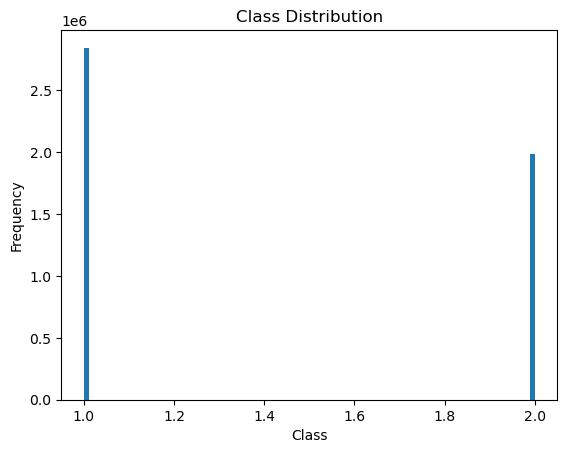

              class        band_1        band_2        band_3        band_4  \
count  4.829329e+06  4.829329e+06  4.829329e+06  4.829329e+06  4.829329e+06   
mean   1.410773e+00  1.593450e-01  1.841300e-01  1.814724e-01  6.517152e-02   
std    4.919742e-01  4.252476e-02  4.345017e-02  5.557799e-02  1.018661e-01   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  1.320064e-01  1.577471e-01  1.396447e-01  0.000000e+00   
50%    1.000000e+00  1.490873e-01  1.745961e-01  1.690361e-01  0.000000e+00   
75%    2.000000e+00  1.736182e-01  1.994202e-01  2.089952e-01  1.750064e-01   
max    2.000000e+00  1.956800e+00  1.843200e+00  1.771200e+00  1.736900e+00   

             band_5        band_6        band_7        band_8        band_9  \
count  4.829329e+06  4.829329e+06  4.829329e+06  4.829329e+06  4.829329e+06   
mean   9.971853e-02  1.114945e-01  3.703854e-01  1.182252e-01  1.176321e+01   
std    1.548828e-01  1.742805e-01  8.763889e-02  1.

class        uint8
band_1     float64
band_2     float64
band_3     float64
band_4     float64
band_5     float64
band_6     float64
band_7     float64
band_8     float64
band_9     float64
band_10    float64
band_11    float64
band_12    float64
band_13    float64
band_14    float64
band_15    float64
dtype: object

In [191]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'combined_df' is your DataFrame and it includes a 'class' column
# Plot a histogram of the 'class' column
plt.hist(combined_df['class'], bins='auto')  # 'auto' lets matplotlib decide the number of bins
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Convert the 'class' column to a numerical format if it's categorical
if combined_df['class'].dtype == 'object':
    le = LabelEncoder()
    combined_df['class'] = le.fit_transform(combined_df['class'])

# Describe the DataFrame to check for Inf, NaNs, or other odd patterns
description = combined_df.describe(include='all')  # include='all' to get statistics for all columns
print(description)

# Print out the schema of the DataFra
combined_df.dtypes

In [119]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, make_scorer
from xgboost import XGBClassifier
import numpy as np

# Assuming 'combined_df' is the DataFrame with your data and 'class' is the target column
y = combined_df['class'].values
#y = combined_df['class'].values - 1  # Subtract 1 to make classes start from 0
X = combined_df.drop(columns=['class']).values

# Initialize the XGBoost classifier
tree = XGBClassifier(random_state=123)  # Tree is a reserved keyword in Python, so we use 'tree' variable

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=6, shuffle=True, random_state=123)

# Define scoring metrics
scoring_metrics = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'kappa': make_scorer(cohen_kappa_score)
}

# Evaluate the model using cross-validation
pe = cross_validate(tree, X, y, cv=cv_strategy, scoring=scoring_metrics, verbose=1)

# Print the measurements
print(f"Balanced Accuracy: {np.mean(pe['test_balanced_accuracy'])}")
print(f"Cohen's Kappa: {np.mean(pe['test_kappa'])}")

Balanced Accuracy: 0.7306945303039541
Cohen's Kappa: 0.65859592856493


In [192]:
# Check the shapes of all rasters in crst
raster_shapes = [raster.shape for raster in crst]
if not all(shape == raster_shapes[0] for shape in raster_shapes):
    print("Not all rasters have the same shape:", raster_shapes)
else:
    print("All rasters have the same shape:", raster_shapes[0])

    # Assuming all rasters are now confirmed to be of the same shape
    dfn = pd.DataFrame({f'band_{i}': raster.flatten() for i, raster in enumerate(crst)})

Not all rasters have the same shape: [(2341, 2928), (2341, 2928), (2341, 2928), (1171, 1464), (1171, 1464), (1171, 1464), (2341, 2928), (1171, 1464), (1, 2341, 2928), (1, 2341, 2928), (1, 2341, 2928), (1, 2341, 2928), (1, 2341, 2928), (1, 2341, 2928), (1, 2341, 2928)]


In [193]:
from rasterio.warp import reproject, calculate_default_transform

def resize_raster_array(array, src_transform, src_crs, target_shape, target_bounds):
    # Calculate the new transform
    new_transform, width, height = calculate_default_transform(
        src_crs, src_crs, target_shape[1], target_shape[0], *target_bounds)
    
    # Set up an empty array for the resampled data
    resampled_array = np.empty((height, width), dtype=array.dtype)

    # Perform the resampling
    reproject(
        source=array,
        destination=resampled_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=new_transform,
        dst_crs=src_crs,
        resampling=Resampling.nearest
    )
    
    return resampled_array

# Assuming 'crst' is your list of rasters (numpy arrays)
# and 'b8' is the file path of a raster with the correct size
with rasterio.open(b8) as src:
    target_shape = src.shape
    src_transform = src.transform
    src_crs = src.crs
    target_bounds = src.bounds

# Resize rasters in 'crst' if needed
resized_crst = [resize_raster_array(raster, src_transform, src_crs, target_shape, target_bounds) if raster.shape != target_shape else raster for raster in crst]

# Convert resized_crst to a DataFrame
dfn = pd.DataFrame({f'band_{i}': raster.flatten() for i, raster in enumerate(resized_crst)})

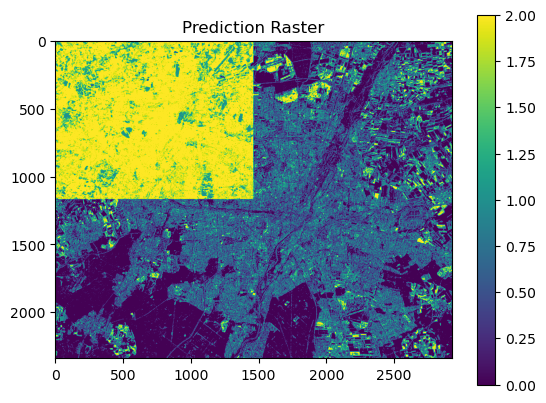

In [194]:
# Assuming 'crst' is a list of rasters (numpy arrays)
# Convert the list of rasters to a DataFrame
#dfn = pd.DataFrame({f'band_{i}': raster.flatten() for i, raster in enumerate(crst)})

# Replace any non-finite values (like Inf) with 0
dfn = dfn.replace([np.inf, -np.inf], 0)

# Train the model
tree.fit(X, y)  # X and y should be your training data and labels

# Now you can make predictions
pred = tree.predict(dfn)

nodata_value = -9999  # You can choose any valid int32 value as the nodata value

# Assuming 'srs' is one of the original rasters and has the same spatial dimensions as 'crst'
with rasterio.open(b8) as src:  # Assuming b8 is a path to one of your rasters
    profile = src.profile
    profile.update(dtype=rasterio.int32, count=1, nodata=nodata_value)

    # Reshape the prediction array to match the spatial dimensions and write to a new raster file
    pred_reshaped = pred.reshape(src.shape).astype(np.int32)
    with rasterio.open('prediction.tif', 'w', **profile) as dst:
        dst.write(pred_reshaped, 1)

plt.imshow(pred_reshaped, cmap='viridis')  # Change colormap as needed
plt.colorbar()
plt.title('Prediction Raster')
plt.show()

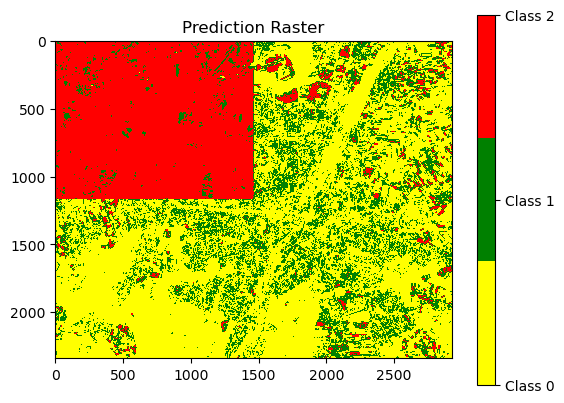

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a new figure and axis object
fig, ax = plt.subplots()

# Define the colors for each class
class_colors = ['yellow', 'green', 'red']  # Class 0 = yellow, 1 = green, 2 = red

# Create a ListedColormap object based on the class colors
cmap = ListedColormap(class_colors)

# Assuming 'pred_reshaped' is your 2D array of predictions
# Replace any non-finite values (like Inf) with the nodata value
pred_reshaped = np.where(np.isfinite(pred_reshaped), pred_reshaped, nodata_value)

# Mask the nodata values so they are not colored in the plot
masked_predictions = np.ma.masked_where(pred_reshaped == nodata_value, pred_reshaped)

# Plot the masked predictions array with the custom colormap
cbar = ax.imshow(masked_predictions, cmap=cmap)

# Optionally, create a colorbar with labels
colorbar_labels = ['Class 0', 'Class 1', 'Class 2']
cbar = fig.colorbar(cbar, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(colorbar_labels)

# Set the title
ax.set_title('Prediction Raster')

# Display the plot
plt.show()

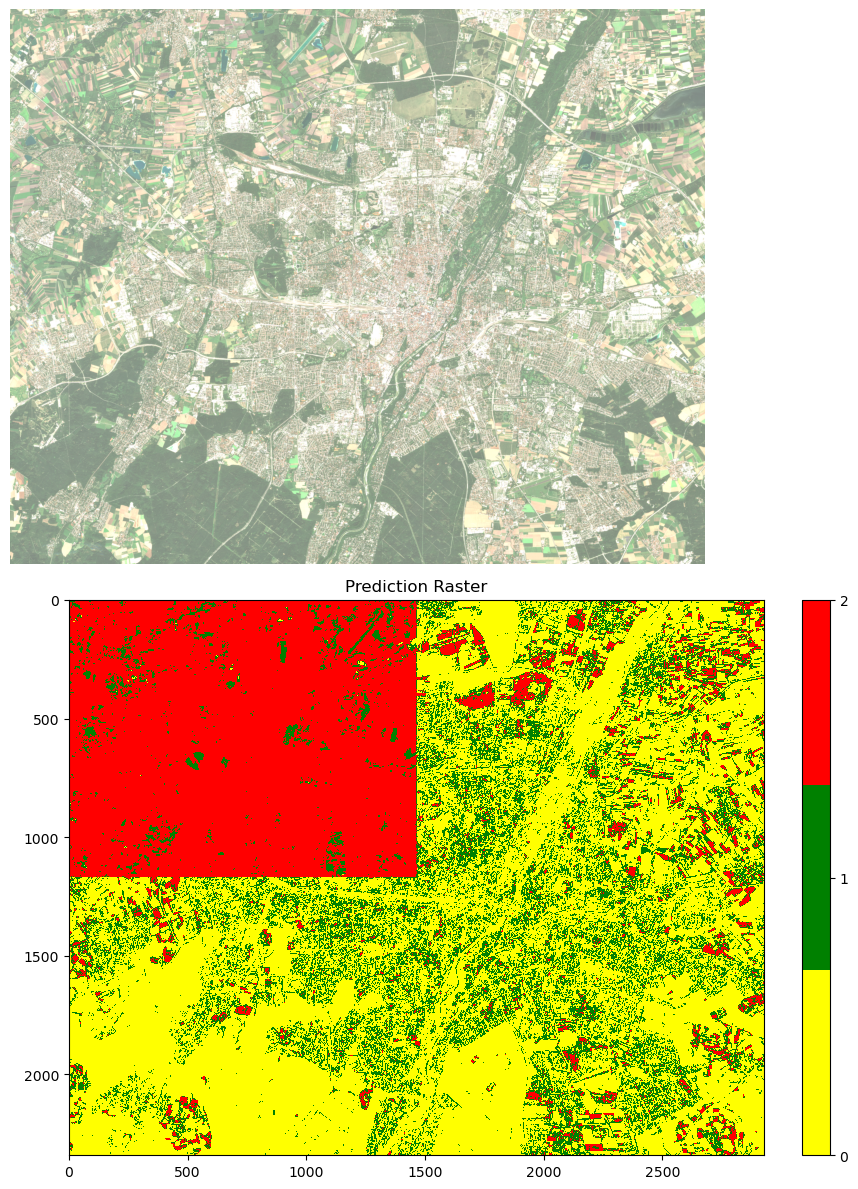

In [198]:
import matplotlib.pyplot as plt

# Your visualization function remains unchanged
def visualize_sentinel2(sentinel2_bands, upper_percentile, ax):
    # Standard RGB composite for Sentinel-2: B04 (Red), B03 (Green), B02 (Blue)
    rgb = np.stack([sentinel2_bands[2], sentinel2_bands[1], sentinel2_bands[0]], axis=-1)
    max_val = np.percentile(rgb, upper_percentile * 100)
    rgb_normalized = np.clip(rgb, 0, max_val) / max_val
    ax.imshow(rgb_normalized)
    ax.axis('off')  # Turn off axis

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Plot the original Sentinel-2 image in the first subplot
visualize_sentinel2(sentinel2_bands, 0.90, ax1)

# Plot the prediction raster in the second subplot
# Assuming 'pred_reshaped' is your 2D numpy array with prediction classes
class_colors = ['yellow', 'green', 'red']  # Class 0 = yellow, 1 = green, 2 = red
cmap = ListedColormap(class_colors)
masked_predictions = np.ma.masked_where(pred_reshaped == nodata_value, pred_reshaped)
cbar = ax2.imshow(masked_predictions, cmap=cmap)
fig.colorbar(cbar, ax=ax2, ticks=[0, 1, 2], fraction=0.036, pad=0.04)  # Adjust colorbar size as needed
ax2.set_title('Prediction Raster')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

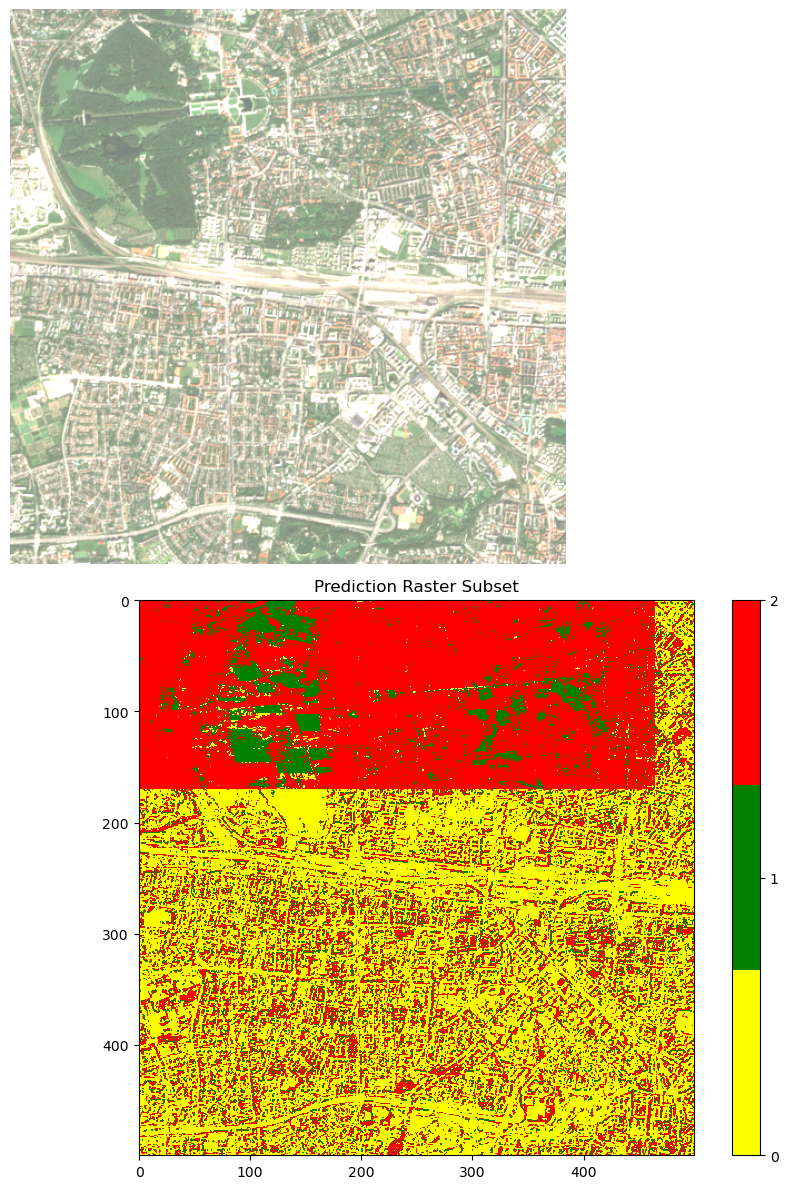

In [199]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the bounds of the subset you want to extract
start_row, start_col = 1000, 1000  # for example
end_row, end_col = 1500, 1500     # for example

# Adjust the visualization function to plot a subset
def visualize_sentinel2_subset(sentinel2_bands, upper_percentile, ax, bounds):
    # Standard RGB composite for Sentinel-2: B04 (Red), B03 (Green), B02 (Blue)
    rgb = np.stack([sentinel2_bands[2], sentinel2_bands[1], sentinel2_bands[0]], axis=-1)
    # Crop the RGB composite image
    rgb_subset = rgb[bounds[0]:bounds[2], bounds[1]:bounds[3], :]
    max_val = np.percentile(rgb_subset, upper_percentile * 100)
    rgb_normalized = np.clip(rgb_subset, 0, max_val) / max_val
    ax.imshow(rgb_normalized)
    ax.axis('off')  # Turn off axis

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Plot the subset of the original Sentinel-2 image in the first subplot
visualize_sentinel2_subset(sentinel2_bands, 0.90, ax1, (start_row, start_col, end_row, end_col))

# Plot the subset of the prediction raster in the second subplot
class_colors = ['yellow', 'green', 'red']  # Class 0 = yellow, 1 = green, 2 = red
cmap = ListedColormap(class_colors)

# Crop the prediction raster to the same subset bounds
pred_subset = pred_reshaped[start_row:end_row, start_col:end_col]

masked_predictions = np.ma.masked_where(pred_subset == nodata_value, pred_subset)
cbar = ax2.imshow(masked_predictions, cmap=cmap)
fig.colorbar(cbar, ax=ax2, ticks=[0, 1, 2], fraction=0.036, pad=0.04)  # Adjust colorbar size as needed
ax2.set_title('Prediction Raster Subset')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()